In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# load dataset
wine = pd.read_csv("winequality-red.csv")

# Dividing wine as good and bad by giving the limit for the quality
bins = (2, 6.5, 8) # 2~6 점 / 7~8점으로 나눠서 둘중 어디 속하는지 맞추기 (binary)
group_names = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_names)

# Now lets assign a labels to our quality variable
label_quality = LabelEncoder()

# Bad becomes 0 and good becomes 1
wine['quality'] = label_quality.fit_transform(wine['quality'])
print(wine['quality'].value_counts())

0    1382
1     217
Name: quality, dtype: int64


In [2]:
wine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,0
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,1
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,1
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,0


In [3]:
#feature_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
#X = wine[feature_cols] # Features

# 이렇게하면 'quality' 만 빼고 나머지 feature로 가능
X = wine.drop('quality', axis = 1)
y = wine.quality # Target variable

In [4]:
from sklearn.model_selection import train_test_split

# 전체 데이터 25%를 테스트, 나머지  train으로 사용
# Train and Test splitting of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Applying Standard scaling to get optimized result
sc = StandardScaler() # 어떤건 0~1이고 어떤건 10단위고 이러니까 

# 이건 뭐하는거지 
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [16]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.style.use('ggplot')
plt.rc('font', size=13)
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True

def draw_conf_matrix(y_test, y_pred, modelname):
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    class_names=['Bad', 'Good'] # name of classes
    tick_marks = [0.5, 1.5]
    fig, ax = plt.subplots()
    
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Pastel1_r", fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix '+'('+modelname+')', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.xticks(tick_marks, class_names, fontsize='15')
    plt.yticks(tick_marks, class_names, fontsize='15')

def draw_ROC_curves(X_train, y_train, X_test, y_test, models, modelnames):
    fprs = []
    tprs = []
    aucs = []
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc)
        
    # ROC Curve
    plt.figure()
    plt.title('ROC Curve')
    for i, modelname in enumerate(modelnames):
        if i == 7:
            # for handling C7 == C0 ..
            plt.plot(fprs[i], tprs[i], label=modelname+", auc="+str(aucs[i])[:6], color='darkslategray')
        else:
            plt.plot(fprs[i], tprs[i], label=modelname+", auc="+str(aucs[i])[:6], color='C'+str(i))
    plt.legend(loc=4, fontsize='15')
    plt.show()
    
def fit_and_draw(modelnames, models, X_train, y_train, X_test, y_test):
    accuracies = []
    precisions = []
    recalls = []
    
    for i, model in enumerate(models):
        # get model name
        modelname = modelnames[i]
        
        # fit the model with data
        model.fit(X_train, y_train)

        # predict
        y_pred = model.predict(X_test)

        # metric
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred, zero_division=0) # 참이라고 하는 것 중에 참인 것 (웹 서치)
        recall = metrics.recall_score(y_test, y_pred) # 전체 참 중에 맞춘 것 (불량 검수)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

        # draw confusion matrix, ROC plot
        draw_conf_matrix(y_test, y_pred, modelname)
    
    # draw roc curves for all models
    draw_ROC_curves(X_train, y_train, X_test, y_test, models, modelnames)
    
    return accuracies, precisions, recalls

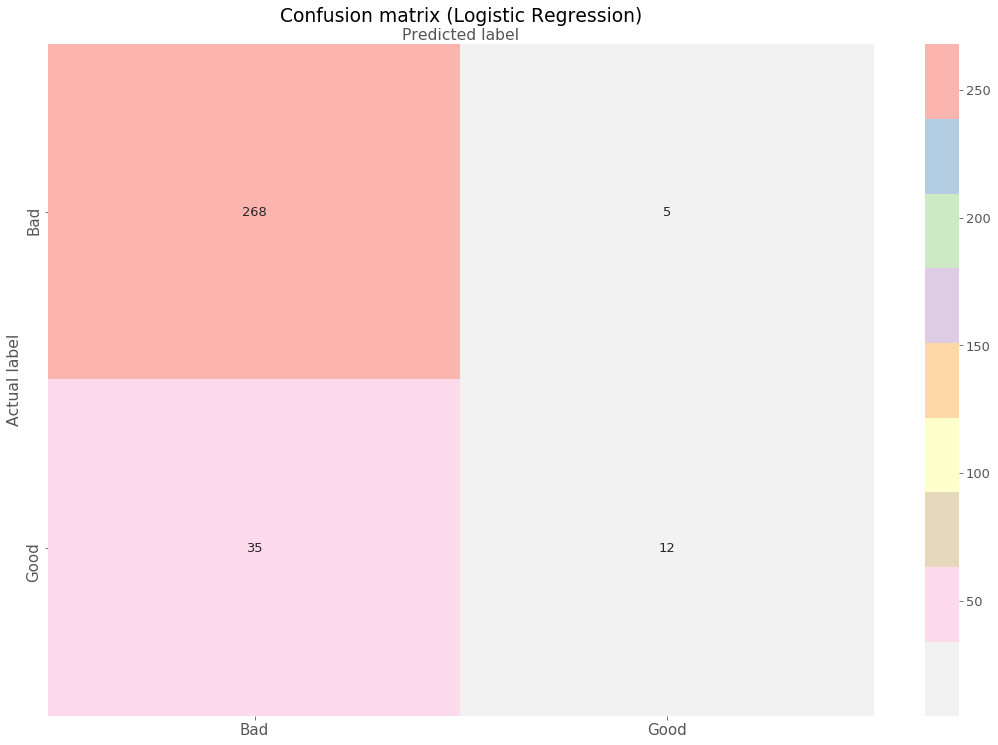

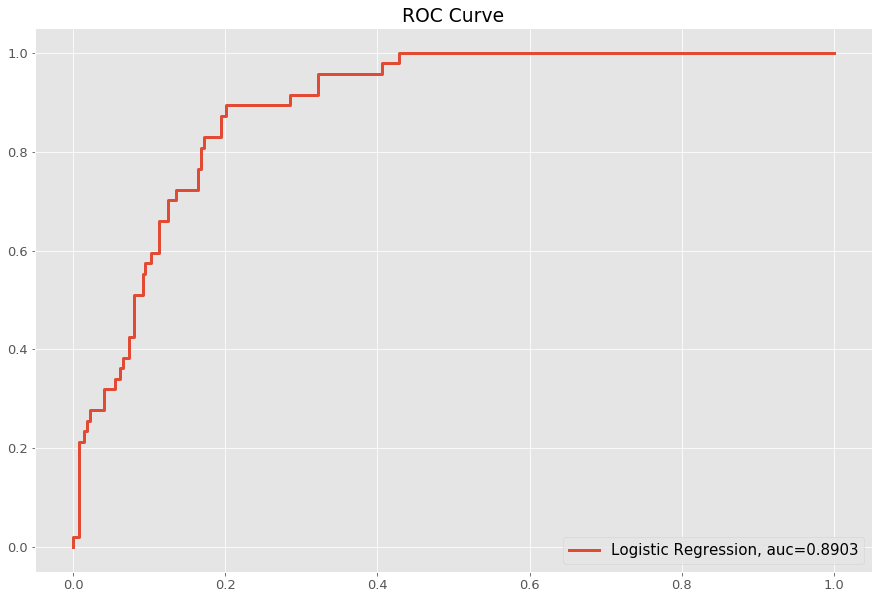

([0.875], [0.7058823529411765], [0.2553191489361702])

In [6]:
# 1. Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=10000)
fit_and_draw(['Logistic Regression'], [model], X_train, y_train, X_test, y_test)

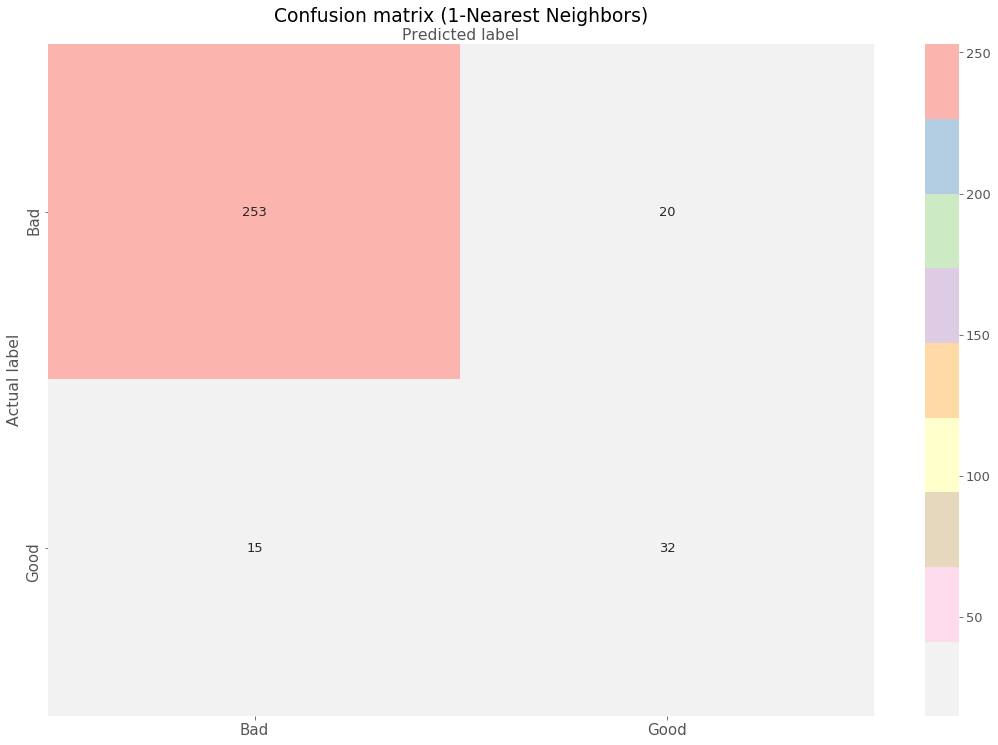

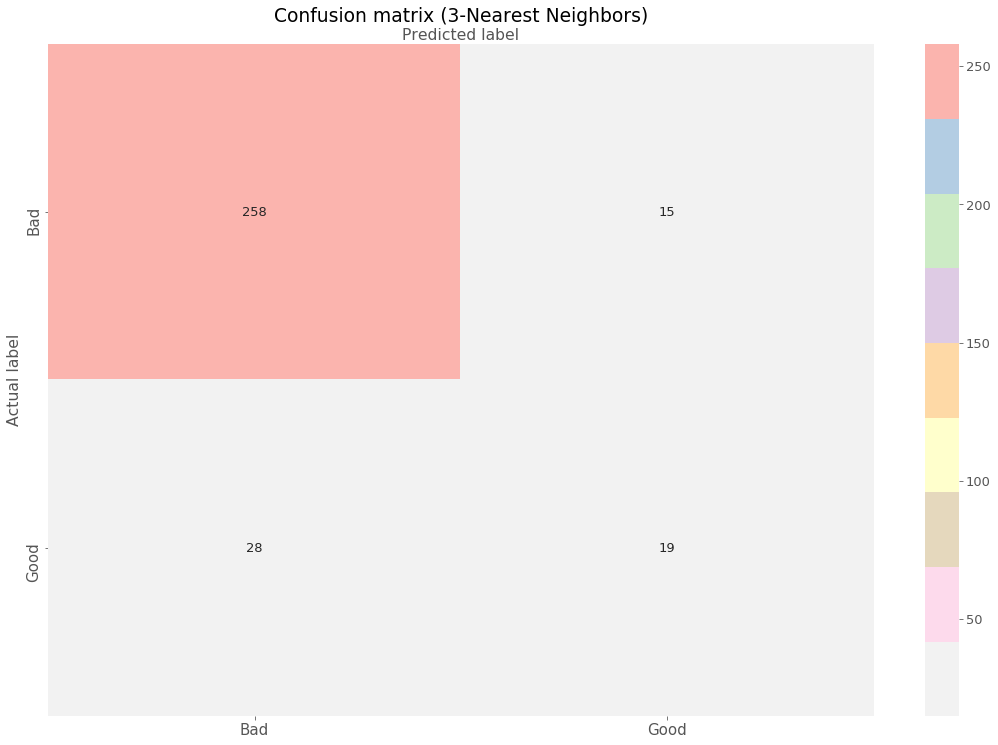

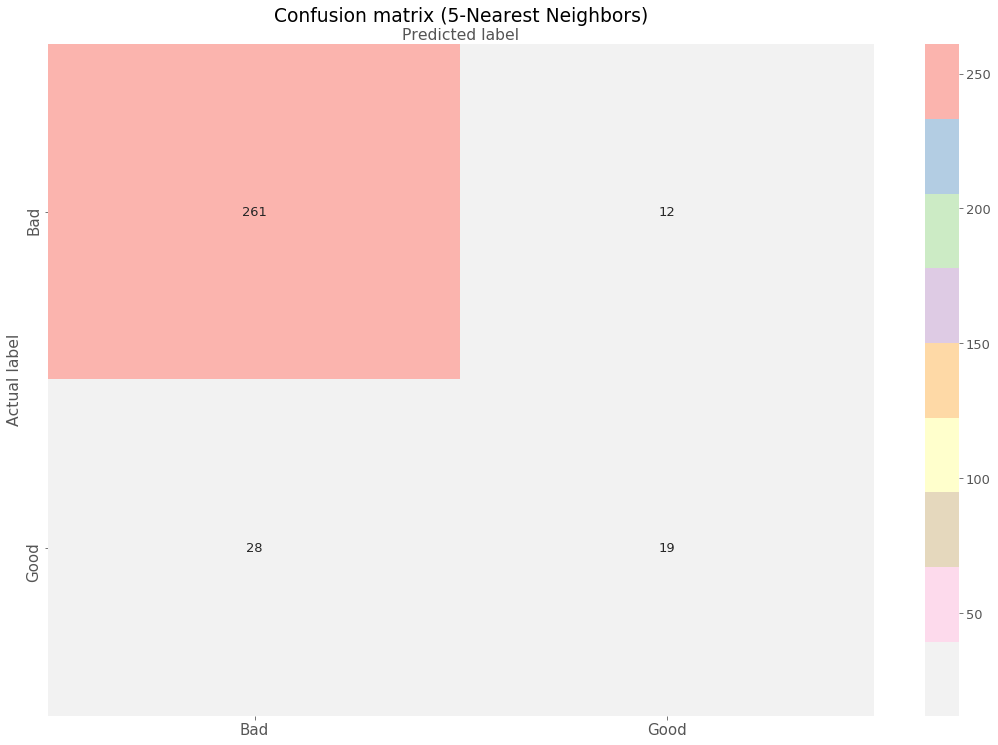

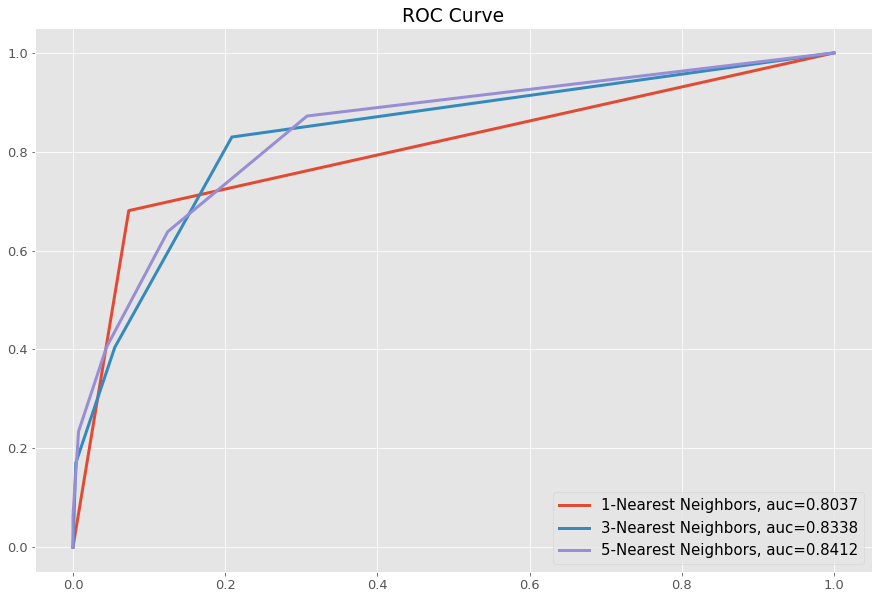

([0.890625, 0.865625, 0.875],
 [0.6153846153846154, 0.5588235294117647, 0.6129032258064516],
 [0.6808510638297872, 0.40425531914893614, 0.40425531914893614])

In [7]:
# 2. Nearest Neighbors
n_neighbors = [1, 3, 5]
models = []
modelnames = []

from sklearn.neighbors import KNeighborsClassifier
for k in n_neighbors:
    model = KNeighborsClassifier(n_neighbors = k) # k=3 인 것. default 5
    models.append(model)
    modelnames.append(str(k)+'-Nearest Neighbors')
fit_and_draw(modelnames, models, X_train, y_train, X_test, y_test)

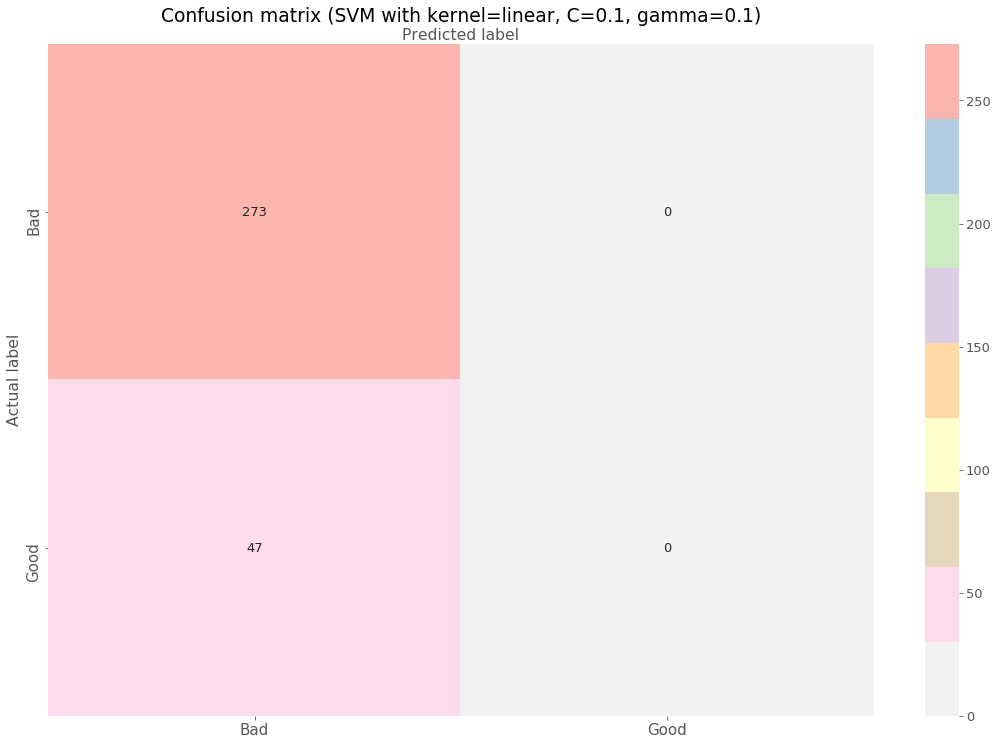

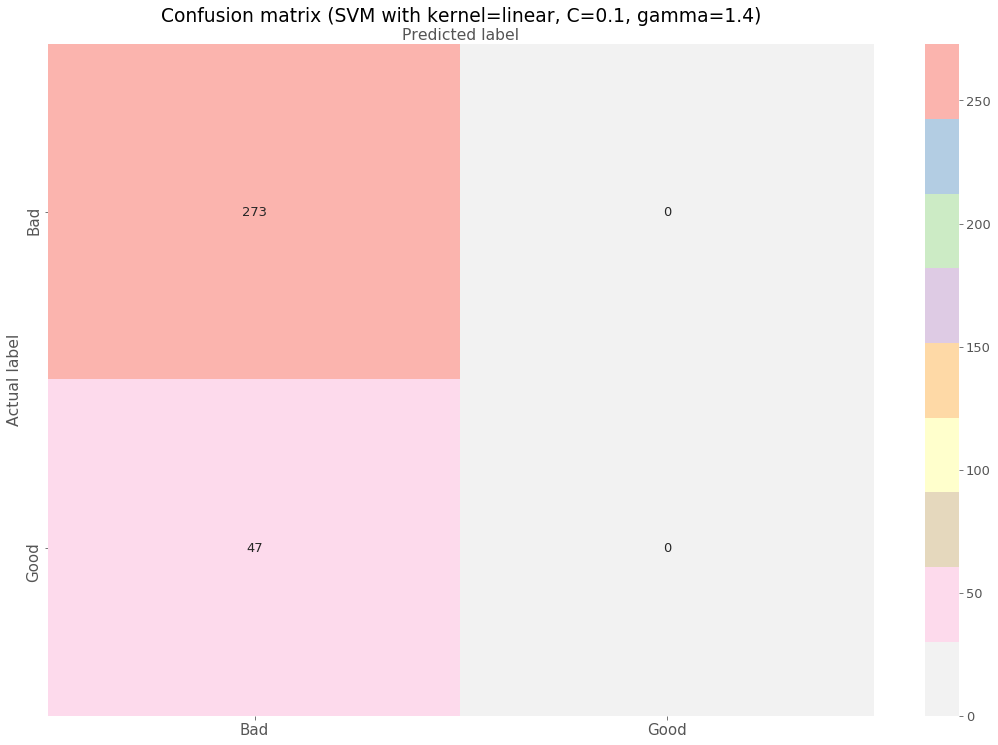

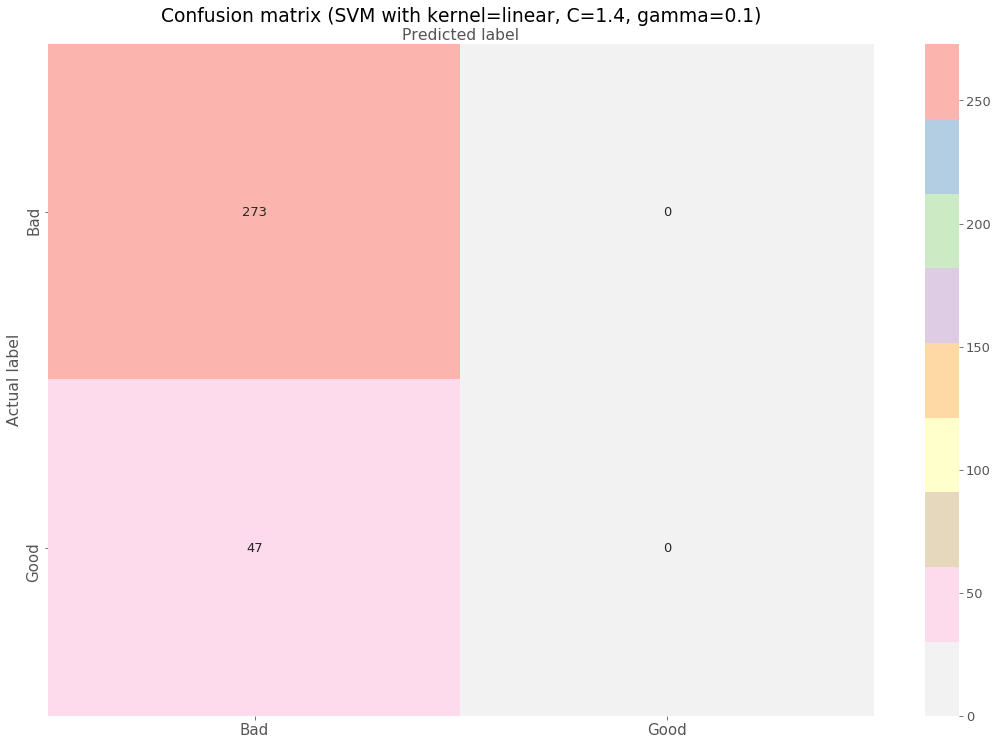

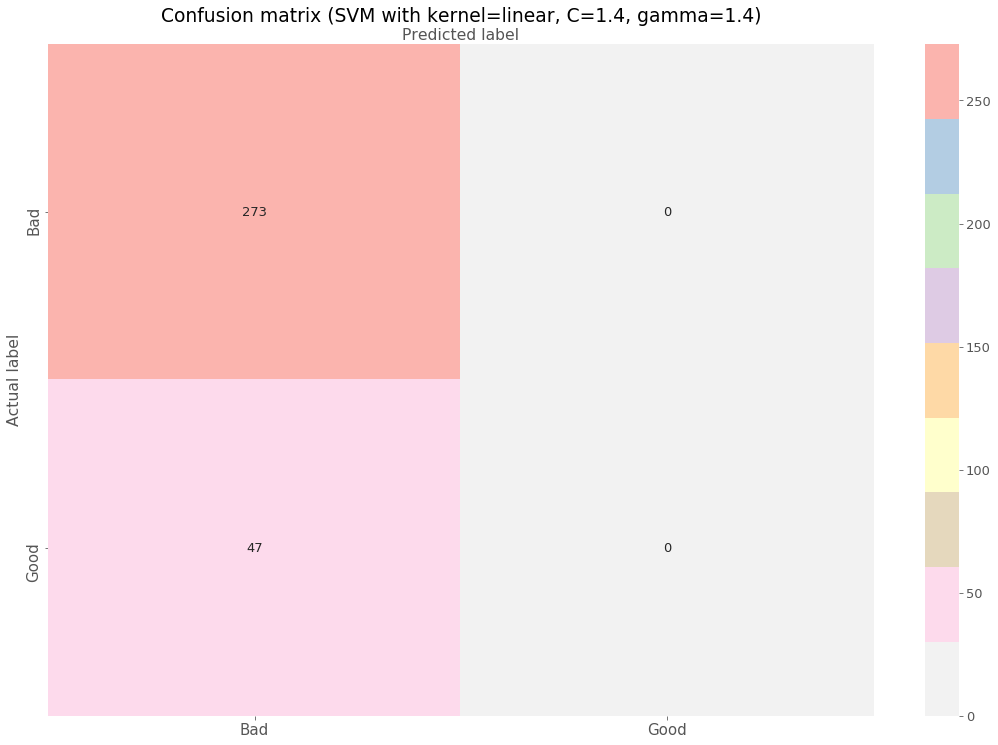

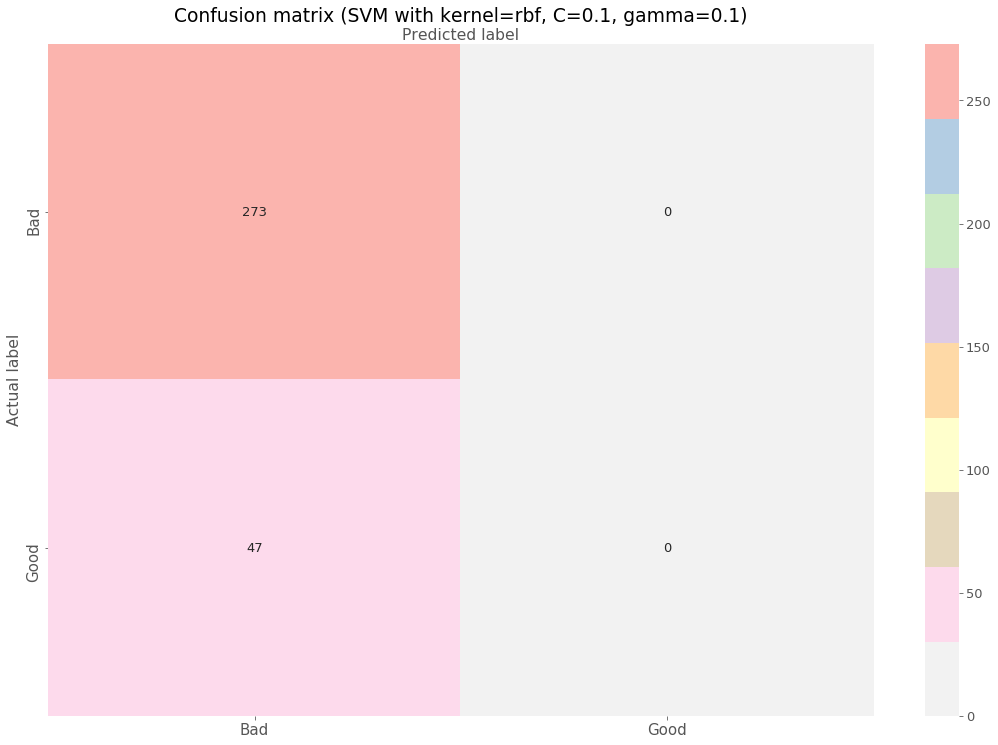

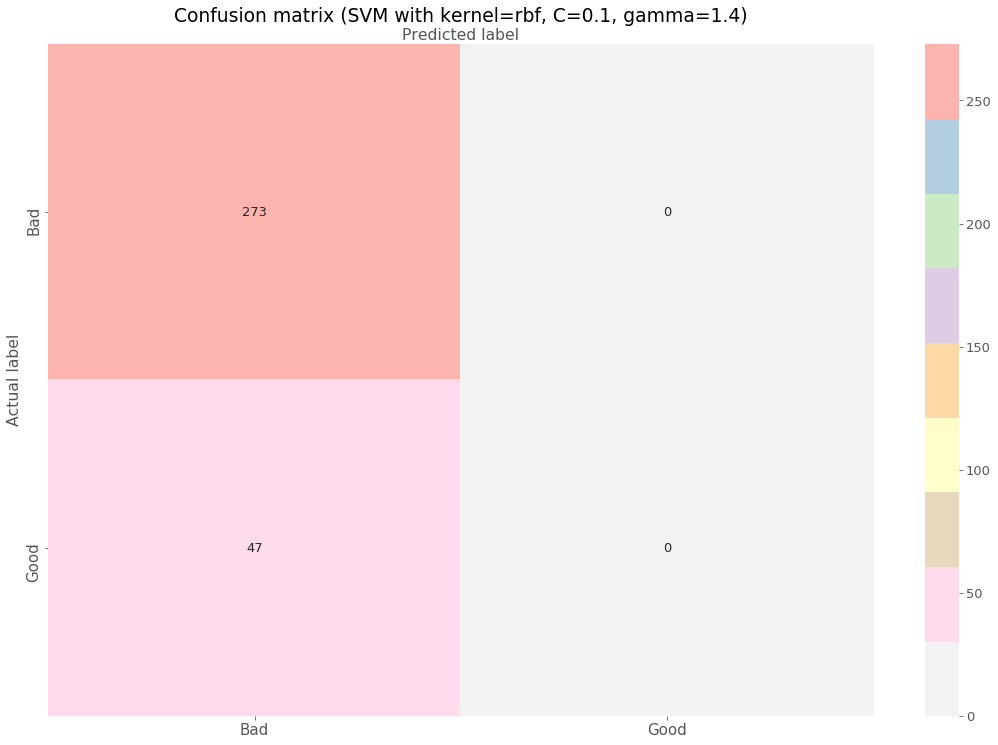

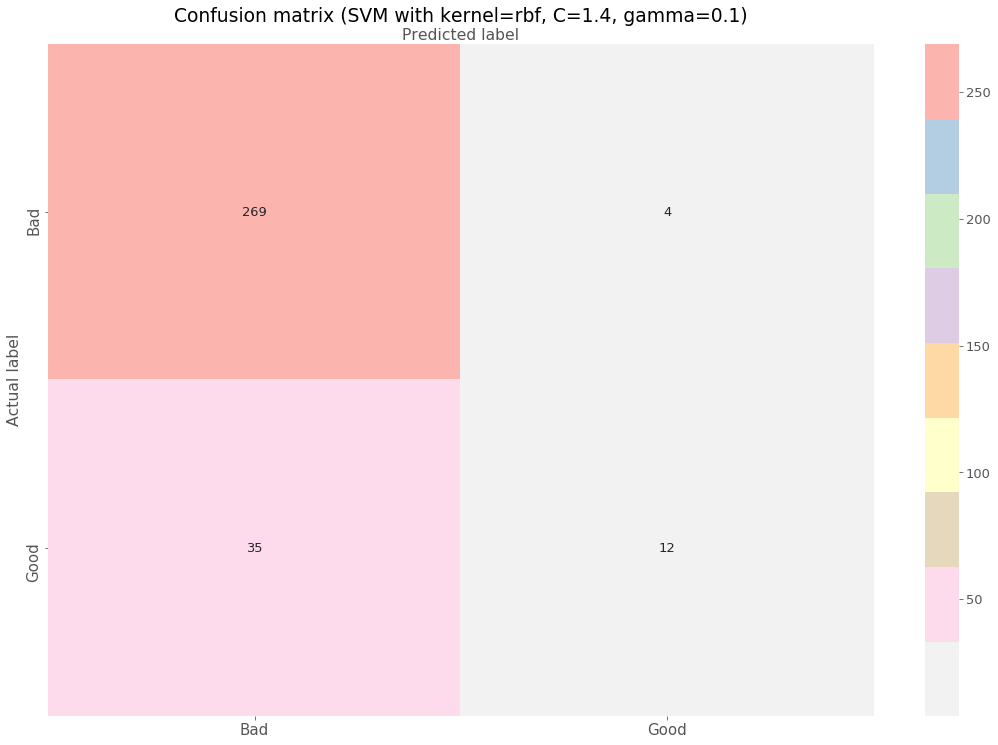

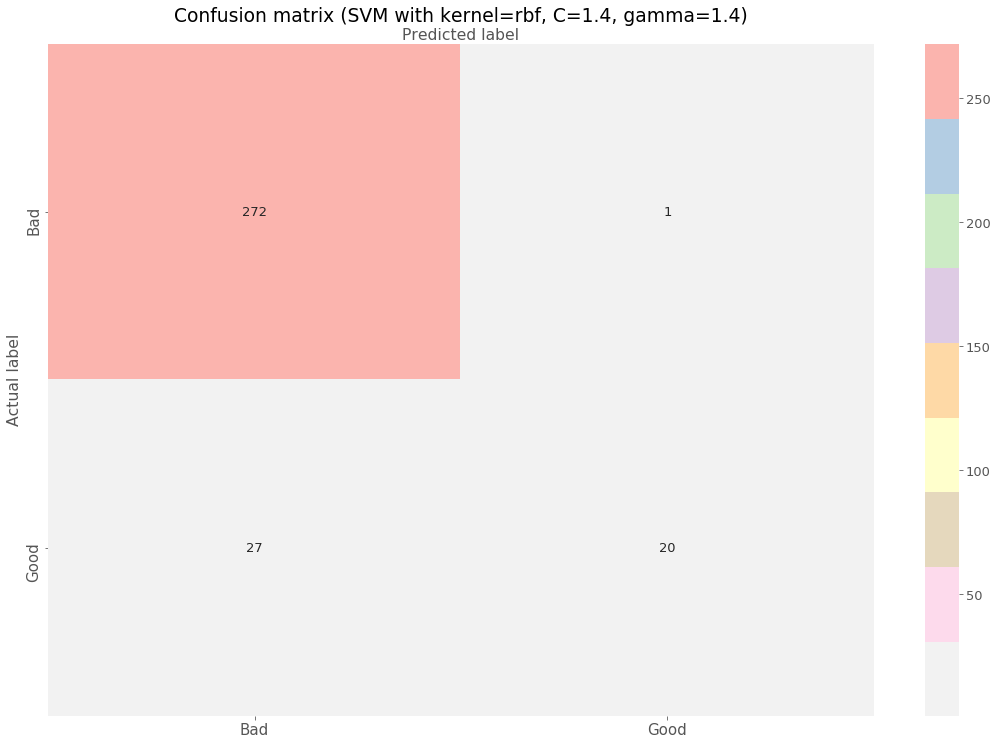

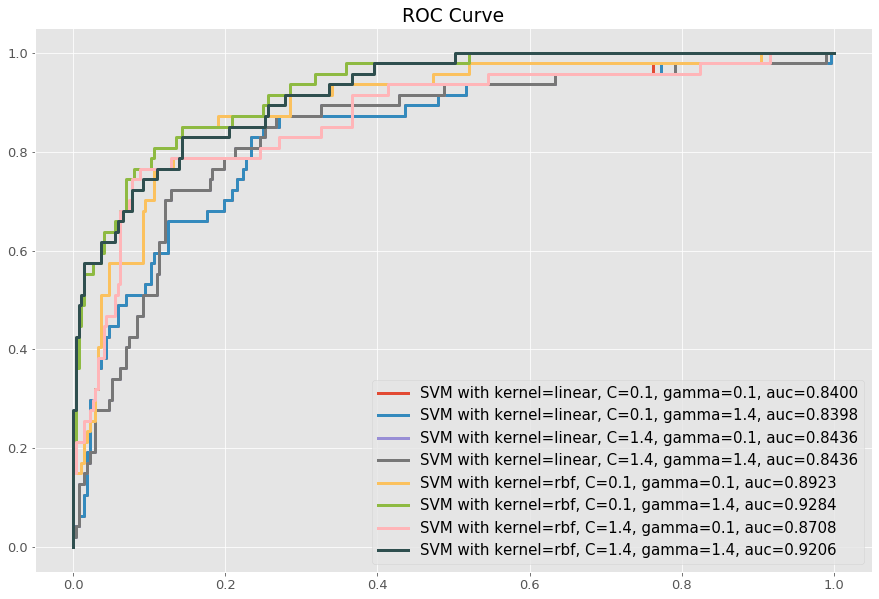

([0.853125,
  0.853125,
  0.853125,
  0.853125,
  0.853125,
  0.853125,
  0.878125,
  0.9125],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.9523809523809523],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2553191489361702, 0.425531914893617])

In [8]:
# 3. Linear SVM (SVC)
C = [0.1, 1.4]
kernel = ['linear', 'rbf']
gamma = [0.1, 1.4]
models = []
modelnames = []

# SVM's models are not supported .predict_proba()
# svc = SVC(probability=True) # Platt calibration
from sklearn import svm

for k in kernel:
    for cc in C:
        for g in gamma:
            model = svm.SVC(kernel=k, C=cc, gamma=g, probability=True)
            models.append(model)
            modelnames.append('SVM with kernel='+str(k)+', C='+str(cc)+', gamma='+str(g))

fit_and_draw(modelnames, models, X_train, y_train, X_test, y_test)

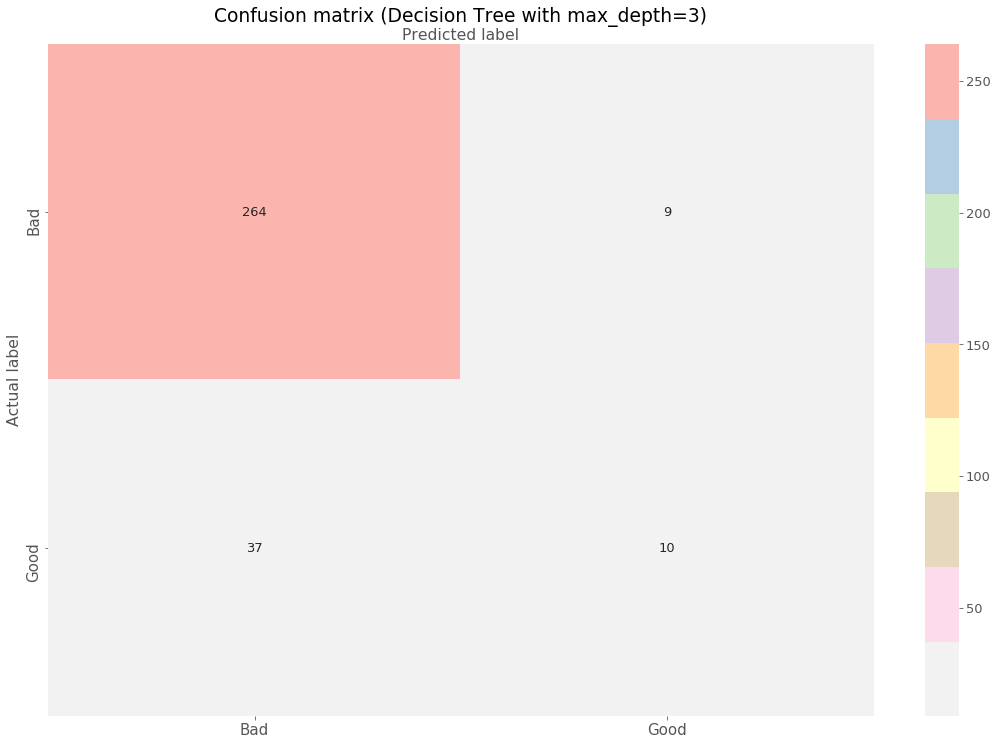

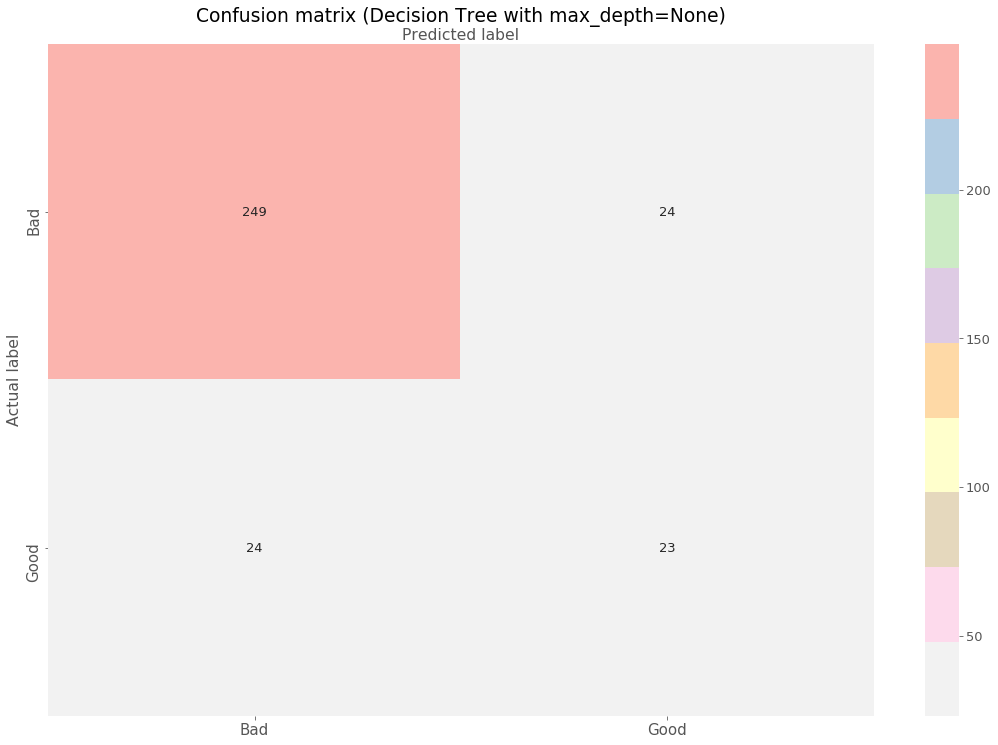

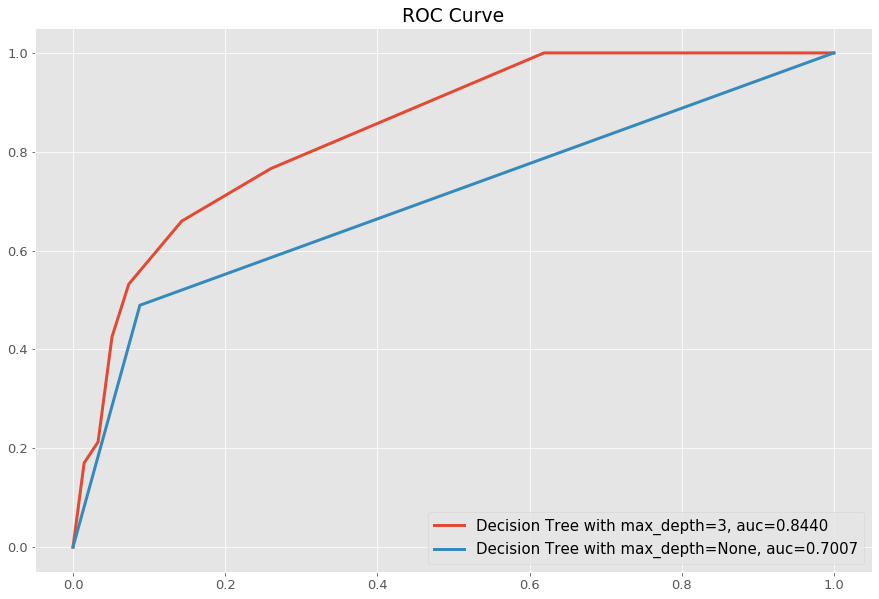

([0.85625, 0.85],
 [0.5263157894736842, 0.48936170212765956],
 [0.2127659574468085, 0.48936170212765956])

In [9]:
#4. Decision Tree
depth = [3, None]
models = []
modelnames = []

from sklearn import tree

for d in depth:
    model = tree.DecisionTreeClassifier(max_depth=d)
    models.append(model)
    modelnames.append('Decision Tree with max_depth='+str(d))
fit_and_draw(modelnames, models, X_train, y_train, X_test, y_test)

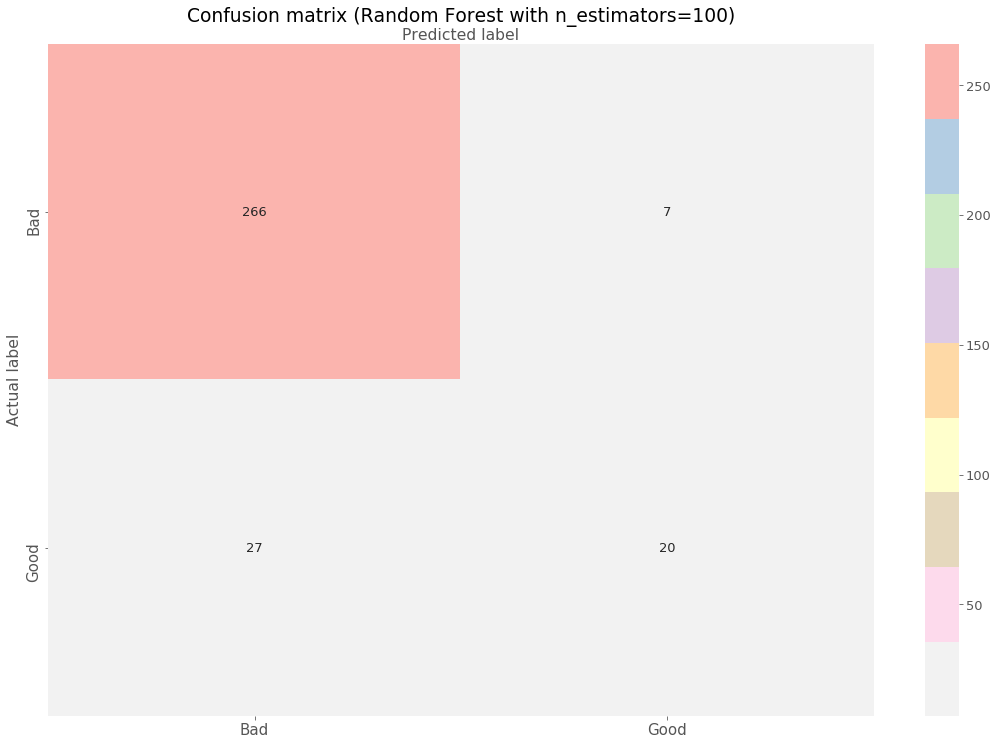

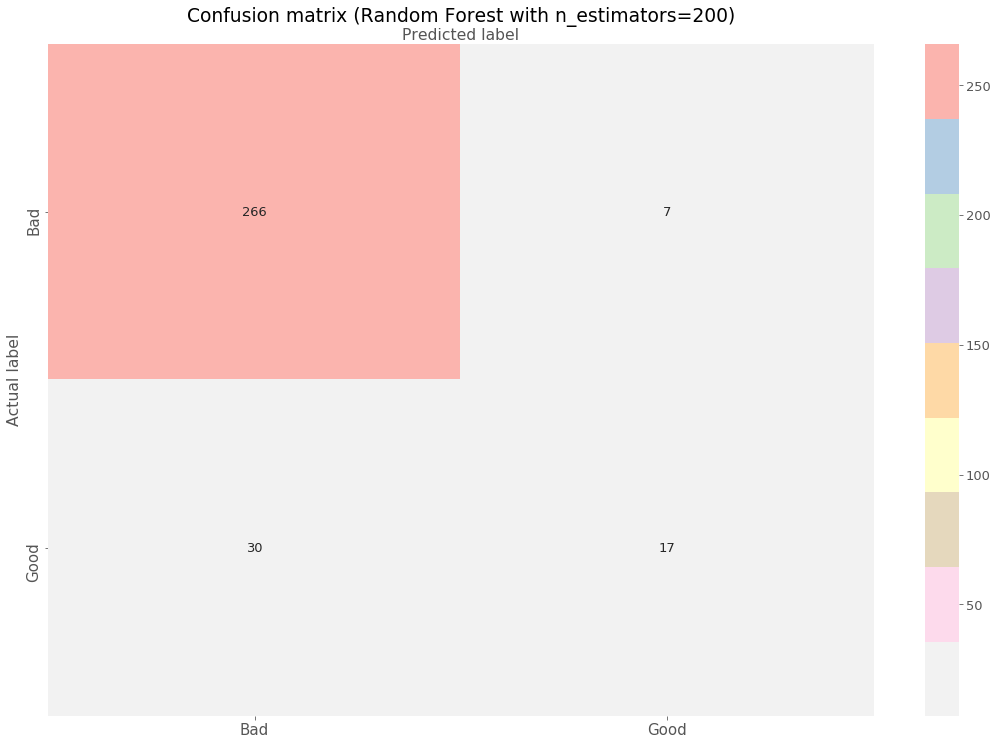

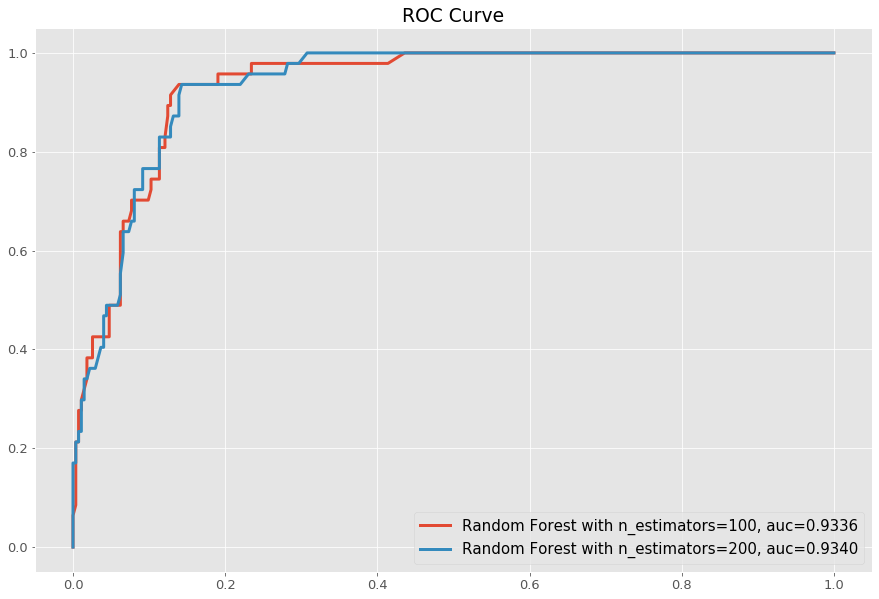

([0.89375, 0.884375],
 [0.7407407407407407, 0.7083333333333334],
 [0.425531914893617, 0.3617021276595745])

In [10]:
# 5. Random Forest Classifier
n_estimators = [100, 200]
models = []
modelnames = []

from sklearn.ensemble import RandomForestClassifier

for n in n_estimators:
    model = RandomForestClassifier(n_estimators=300) # 이 알고리즘의 특징은 Prec높은데 Recall 이 엉망인 것
    models.append(model)
    modelnames.append('Random Forest with n_estimators='+str(n))
fit_and_draw(modelnames, models, X_train, y_train, X_test, y_test)

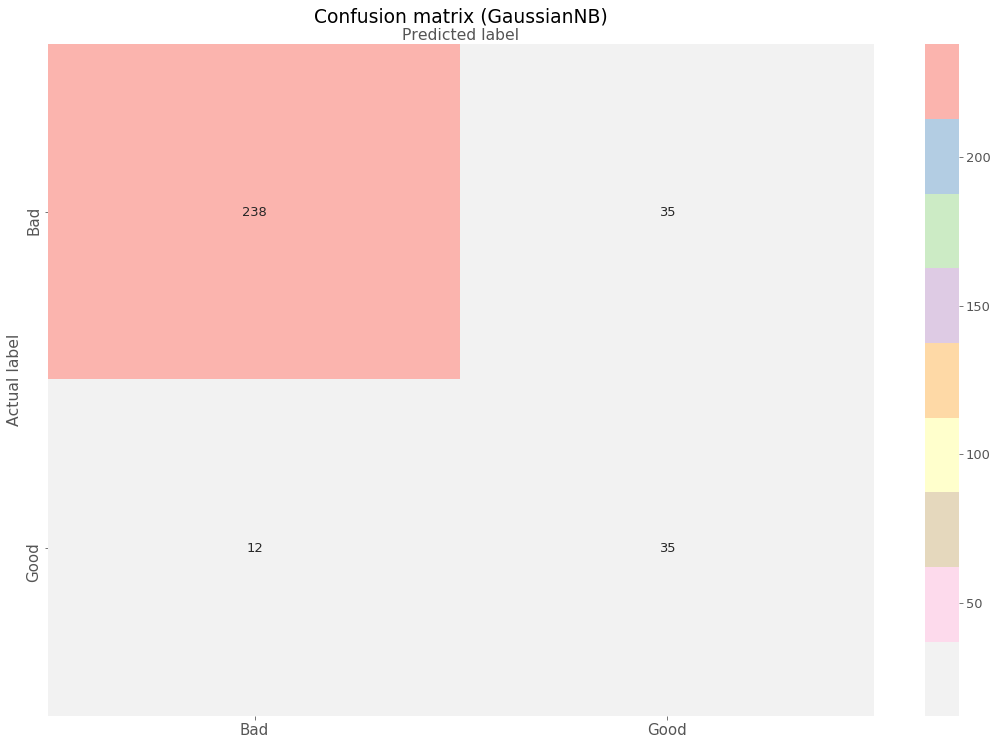

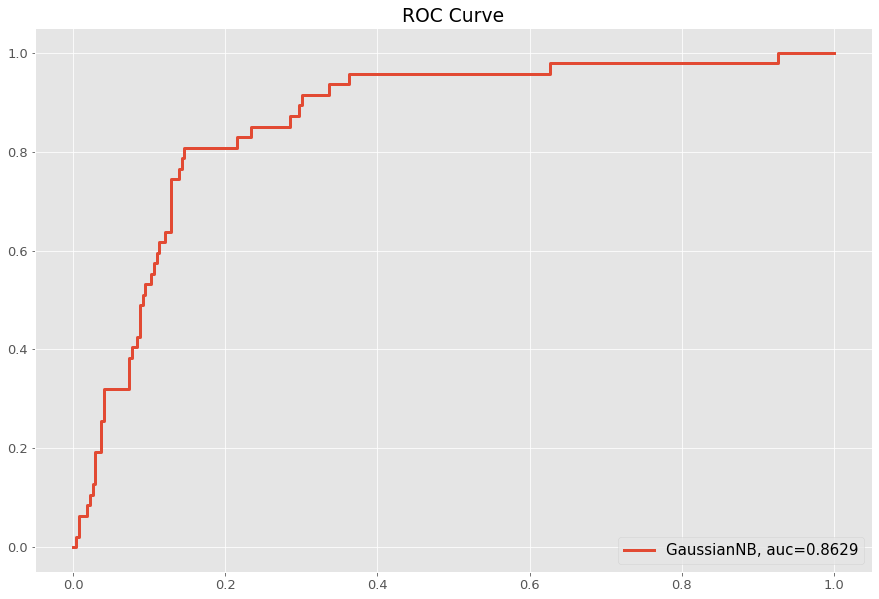

([0.853125], [0.5], [0.7446808510638298])

In [11]:
# 6. GaussianNB
models = []
modelnames = []

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
models.append(model)
modelnames.append('GaussianNB')
fit_and_draw(modelnames, models, X_train, y_train, X_test, y_test)

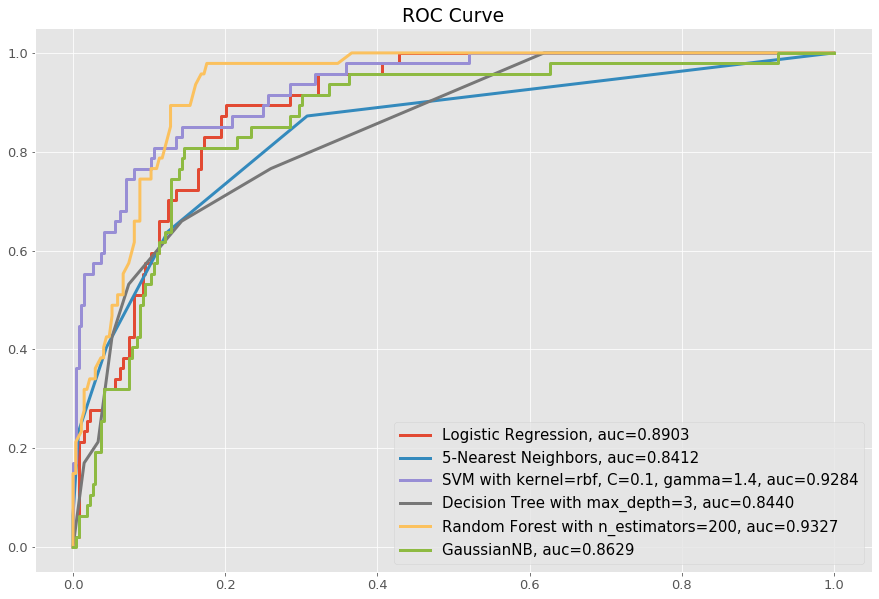

In [17]:
# 모든 모델들에서 가장 잘 나온 파라미터들에 대해 ROC커브 비교
model1 = LogisticRegression(max_iter=10000)
model2 = KNeighborsClassifier(n_neighbors = 5)
model3 = svm.SVC(kernel='rbf', C=0.1, gamma=1.4, probability=True)
model4 = tree.DecisionTreeClassifier(max_depth=3)
model5 = RandomForestClassifier(n_estimators=200) # 이 알고리즘의 특징은 Prec높은데 Recall 이 엉망인 것
model6 = GaussianNB()

modelname1 = 'Logistic Regression'
modelname2 = '5-Nearest Neighbors'
modelname3 = 'SVM with kernel=rbf, C=0.1, gamma=1.4'
modelname4 = 'Decision Tree with max_depth=3'
modelname5 = 'Random Forest with n_estimators=200'
modelname6 = 'GaussianNB'

models = [model1, model2, model3, model4, model5, model6]
modelnames = [modelname1, modelname2, modelname3, modelname4, modelname5, modelname6]

draw_ROC_curves(X_train, y_train, X_test, y_test, models, modelnames)